## function adapted from previous lab

In [1]:
def custanalysis(data,correl,testsize,randomstate):

    ####importing all libraries needed 
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy import stats
    import statsmodels.api as sm
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.model_selection import train_test_split
    
    import warnings
    warnings.filterwarnings("ignore")

######### from lab2

    #importing file
    data=pd.read_csv(data)
        
    print("Data shape:", data.shape)
    
    print("""""")
    print("Standardized data columns: ", data.columns)
    
    numerical_cols=data.select_dtypes(include=['int', 'float']).columns
    print("""""")
    print("Numerical Columns: ", numerical_cols)
    
    categorical_cols=data.select_dtypes(include=['object']).columns
    print("""""")
    print("Categorical Columns: ",categorical_cols)
    
    #clean data
    nulls_df=pd.DataFrame(data.isna().sum()/len(data)*100).reset_index() #formatar em tabela
    nulls_df.columns=['column_name','percent_nulls']
    
    columns_to_drop = nulls_df[nulls_df['percent_nulls']>=50]['column_name'].values
    data = data.drop(columns_to_drop, axis=1)
    
    #droping duplicates
    data=data.drop_duplicates()
    
    #drop NaN values
    data=data.dropna(axis=0)

    data['Effective To Date'] = pd.to_datetime(data['Effective To Date'],errors="coerce")
    data['Month'] = data['Effective To Date'].dt.month
    
    data = data[data['Month'].isin([1, 2, 3])]
    
    print("""""")
    print("Final data filtered is: ")
    display(pd.DataFrame(data))

########## from lab3
    #describe data
    print("""""")
    print("Data description: ")
    print("""""")
    display(pd.DataFrame(data.describe().T))
    
    #plot total number of responses
    sns.histplot(data["Response"],bins=2)
    print("""""")
    print("""""")
    print("Count of Responses: ")
    plt.show()
    
    #plot of the response rate by the sales channel
    tot_resp=data["Response"].count()
    yes_resp=data['Response'].value_counts()['Yes']
    percentage = yes_resp/tot_resp*100
    
    #loop to get the %response rate by channel
    sales_channels=[]
    resp_rates=[]
    for channel in data["Sales Channel"].unique():
        sales_channels.append(channel)
        filtered=data[(data['Sales Channel']==channel)]
        tot_resp=filtered["Response"].count()
        yes_resp=filtered['Response'].value_counts()['Yes']
        percentage = yes_resp/tot_resp*100
        resp_rates.append(percentage)
    print("""""")
    print("""""")
    print("Response Rates: ")    
    plt.bar(x=sales_channels, height=resp_rates)
    plt.xlabel("Sales Channel")
    plt.ylabel("Response Rate [%]")
    plt.ylim(0, 20)  #limites eixo y
    plt.show()
    
    # Create income groups
    median_income = data['Total Claim Amount'].median()
    claim_bins = pd.cut(data['Total Claim Amount'], bins=[0, median_income, float('inf')], labels=['Low claim', 'High claim'])

    # Calculate response rate by claim group
    response_rates = data.groupby(claim_bins)['Response'].value_counts(normalize=True).loc[:, 'Yes'] * 100

    # Plot the response rate by claim group
    plt.figure(figsize=(8, 6))
    response_rates.plot(kind='bar')
    plt.title('Response rate by claim group')
    plt.xlabel('Claim group')
    plt.ylabel('Response rate (%)')
    plt.show()
    
    # Create income groups
    median_income = data['Income'].median()
    income_bins = pd.cut(data['Income'], bins=[0, median_income, float('inf')], labels=['Low income', 'High income'])

    # Calculate response rate by income group
    response_rates = data.groupby(income_bins)['Response'].value_counts(normalize=True).loc[:, 'Yes'] * 100

    # Plot the response rate by income group
    plt.figure(figsize=(8, 6))
    response_rates.plot(kind='bar')
    plt.title('Response rate by income group')
    plt.xlabel('Income group')
    plt.ylabel('Response rate (%)')
    plt.show()

############ from lab4
    #dividir entre numericos e categoricos
    numeric = data.select_dtypes(include=[np.number])
    categoric = data.select_dtypes(include=[np.object])
    
    #definir Y
    Y=numeric["Total Claim Amount"]
    #definir X
    numeric=numeric.drop(["Total Claim Amount"],axis=1)
    
    print("""""")
    print('\033[1m'+"Numeric columns plots"+'\033[1m')
    print("""""")  
    
    for col in numeric.columns:
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
        
        # Plot the history plot on the first subplot
        sns.histplot(numeric[col], ax=ax1)
        ax1.set_title(f'{col} - History Plot')
        
        # Plot the dist plot on the second subplot
        sns.kdeplot(numeric[col], ax=ax2)
        ax2.set_title(f'{col} - Dist Plot')
        
        # Set the tight layout and display the figure
        plt.tight_layout()
        plt.show()
    
    print("""""")
    print('\033[1m'+"Correlation Heatmap"+'\033[1m')
    print("""""")
    
    #heatmap correlation
    sns.heatmap(numeric.corr(),annot=True)
    plt.show()
    numeric.corr()
    
    #check if there are columns to drop with high correlation
    correlation=numeric.corr()
    cols_to_drop=[]

    for i in range(len(correlation.columns)):
        for j in range(len(correlation)):
            if correlation.iloc[i,j] == 1.0:
                pass
            elif correlation.iloc[i,j]>correl: #variable that can change the dropped columns

                cols_to_drop.append(correlation.columns[i])

    if not cols_to_drop:
        print('\033[1m'+"There are no high-correlation columns, thus no column was dropped."+'\033[1m')
    else:
        numeric = numeric.drop(columns=cols_to_drop)
        print('\033[1m'+"The following high-correlation columns were dropped: "+'\033[1m',cols_to_drop)
        print("""""")  #paragraph
        print("New numerical data: ")
        display(numeric) 
        
########### from lab5&6

    numeric_x=numeric.drop(["Number of Open Complaints","Number of Policies"],axis=1)
    numeric_x["Income"]=numeric_x["Income"].replace(0,numeric_x["Income"].mean())
    
    print("""""")
    print("""""")
    print('\033[1m'+"Normalizing with BoxCox"+'\033[1m')
    
    for col in numeric_x.columns:
        numeric_x[col]=numeric_x[col].replace(0,numeric_x[col].mean())
        arr, lmbda=stats.boxcox(numeric_x[col])
        numeric_x[col]=arr
        sns.histplot(arr)
        plt.title(f"{col}")
        plt.show()
    
    print('\033[1m'+"Applying One Hot"+'\033[1m')
    print("""""")
    print("""""")    
       
    categoric=categoric.drop(["Customer"],axis=1)
    
    #loop para gravar nomes do one hot
    one_hot_names = []
    for col in categoric.columns:
        col_uniques = sorted(categoric[col].unique())
        for unique in col_uniques:
            one_hot_names.append(col+"_"+unique)


    categoric_x = pd.DataFrame(OneHotEncoder().fit(pd.DataFrame(categoric))
                             .transform(pd.DataFrame(categoric)).toarray())
    categoric_x.columns = one_hot_names
    
    #concatenate numeric and categoric X data
    data_w=pd.DataFrame(np.concatenate((numeric_x,categoric_x),axis=1)).reset_index(drop=True)
    data_w.columns = list(numeric_x.columns) + list(categoric_x.columns)
    
    print('\033[1m'+"Final X data:"+'\033[1m')
    
    display(pd.DataFrame(data_w))
    
    print("""""")
    print("""""")
    print('\033[1m'+"Train-test Split:"+'\033[1m')
    
    #final X
    X=data_w
       
    x_train, x_test, y_train, y_test=train_test_split(X,Y,test_size=testsize,random_state=randomstate) #variables to change
    model=sm.OLS(y_train,x_train).fit()
    
    predictions=model.predict(x_test)
    
    #comparison between real Y and predictions
    comparison=pd.concat([y_test,predictions],axis=1)
    comparison.columns=["y_test","predictions"]
    comparison=comparison.reset_index()
    comparison=comparison.drop(["index"],axis=1)
    display(pd.DataFrame(comparison))
       
    r2=r2_score(y_test,predictions)
    print("""""")    
    print("R2 score: ",r2)
    
    mse=mean_squared_error(y_test,predictions)

    print("MSE: ",mse)
    
    rmse=mean_squared_error(y_test,predictions,squared=False)

    print("RMSE: ",rmse)
    
    mae=mean_absolute_error(y_test,predictions)
    print("MAE: ",mae)
    print("""""")
    print("""""")
    
    return

Data shape: (9134, 24)

Standardized data columns:  Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

Numerical Columns:  Index(['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies',
       'Total Claim Amount'],
      dtype='object')

Categorical Columns:  Index(['Customer', 'State', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marita

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Month
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,...,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,2
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,...,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,1
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,...,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,2
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,...,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,1
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,...,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2011-02-10,Employed,M,71941,...,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize,2
9130,PK87824,California,3096.511217,Yes,Extended,College,2011-02-12,Employed,F,21604,...,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize,2
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2011-02-06,Unemployed,M,0,...,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize,2
9132,UP19263,California,7524.442436,No,Extended,College,2011-02-03,Employed,M,21941,...,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large,2



Data description: 



,count,mean,std,min,25%,50%,75%,max
Customer Lifetime Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly Premium Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months Since Last Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months Since Policy Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number of Open Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number of Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total Claim Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678
Month,9134.0,1.463762,0.498712,1.000000,1.000000,1.000000,2.000000,2.000000




Count of Responses: 


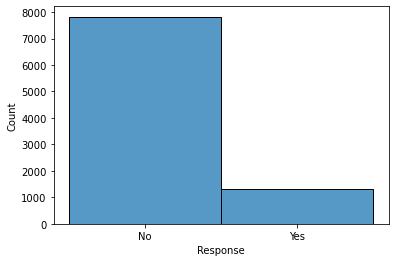



Response Rates: 


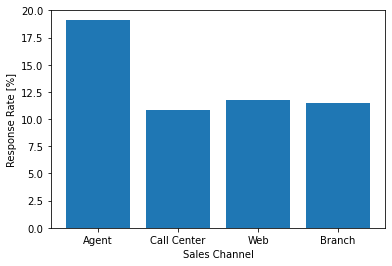

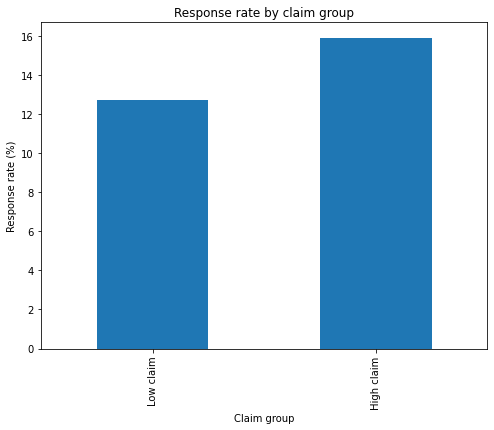

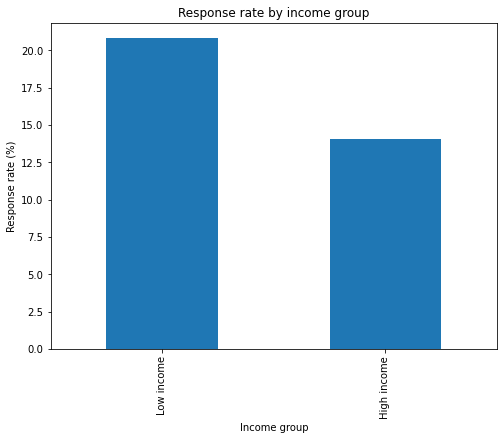


Numeric columns plots



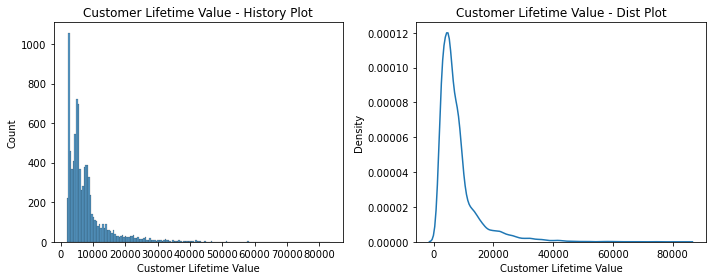

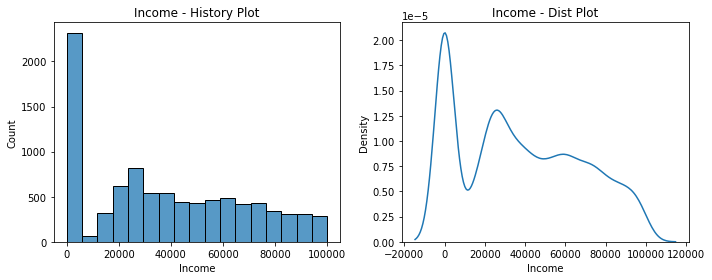

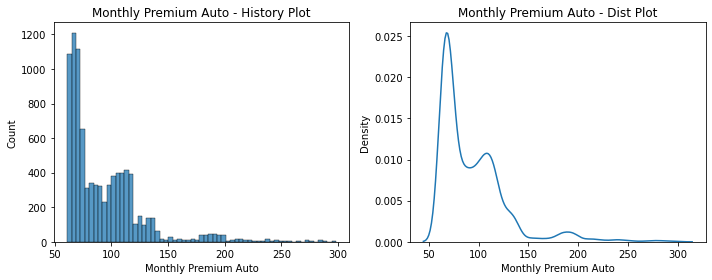

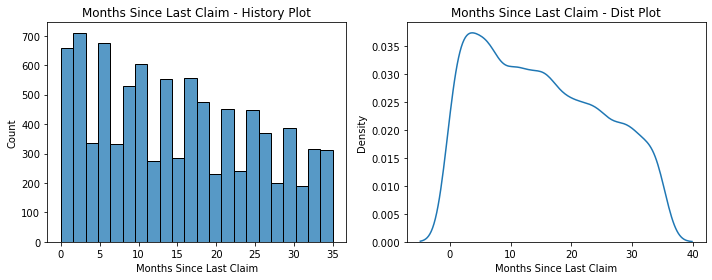

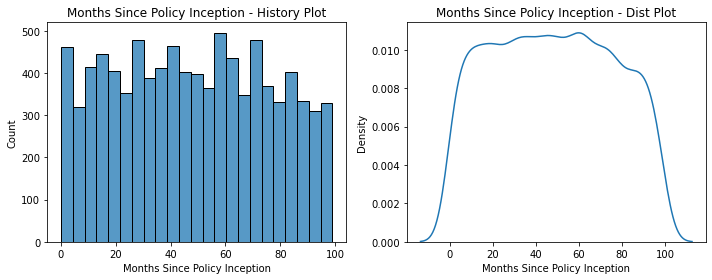

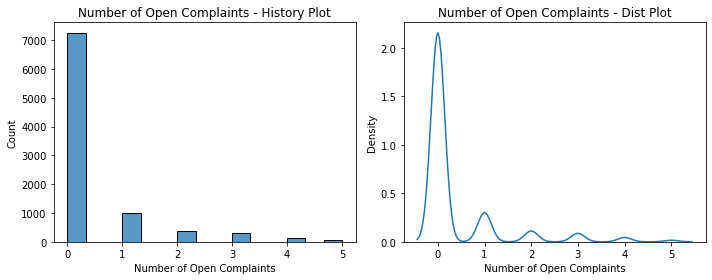

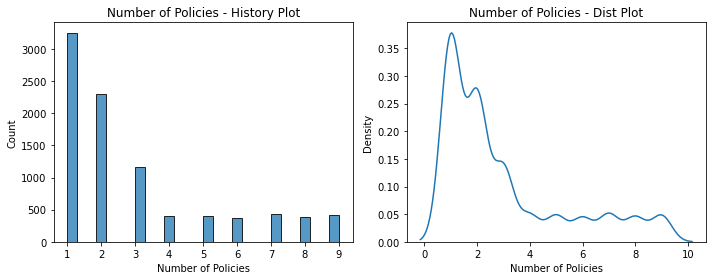

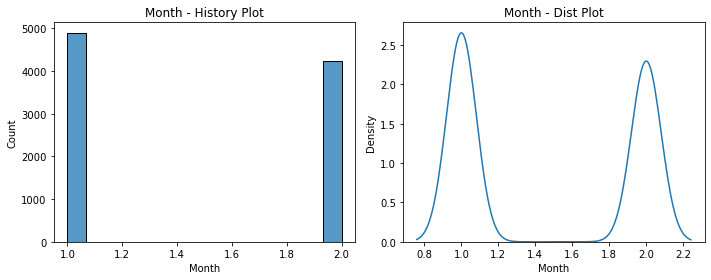


Correlation Heatmap



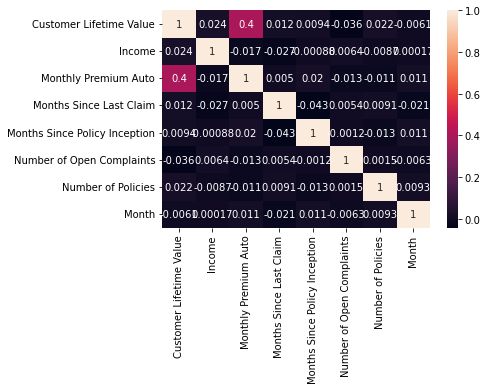

There are no high-correlation columns, thus no column was dropped.


Normalizing with BoxCox


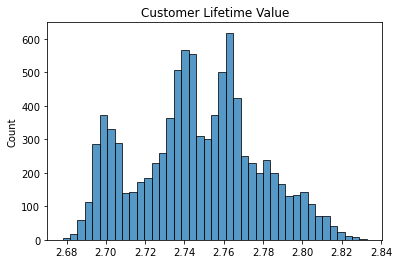

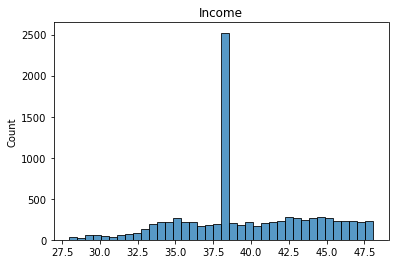

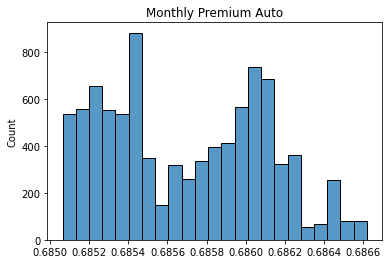

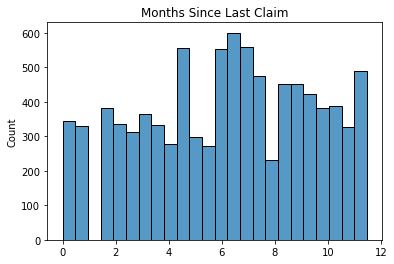

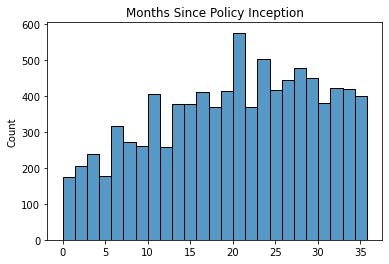

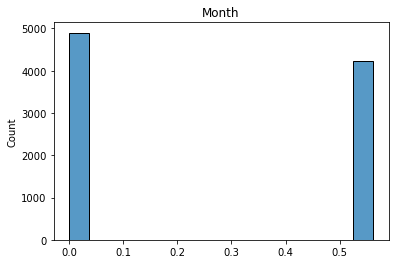

Applying One Hot


Final X data:


,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Month,State_Arizona,State_California,State_Nevada,State_Oregon,...,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small
0,2.703839,42.114983,0.685347,10.809132,3.017301,0.561741,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2.754926,38.346277,0.685871,5.783269,18.770387,0.000000,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.780772,40.735368,0.686039,7.311427,17.380225,0.561741,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2.759125,38.346277,0.686018,7.311427,26.144855,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2.704995,39.734641,0.685461,5.448624,19.451130,0.561741,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,2.801170,44.579684,0.685461,7.311427,33.067968,0.561741,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9130,2.711030,33.627127,0.685606,6.106927,13.703207,0.561741,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9131,2.762062,38.346277,0.685725,4.363742,17.026248,0.561741,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9132,2.758397,33.751319,0.685898,11.248499,1.667661,0.561741,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0




Train-test Split:


,y_test,predictions
0,396.105473,512.972811
1,413.492922,548.767795
2,333.696228,343.696624
3,558.099357,469.281172
4,806.400000,808.789571
...,...,...
2736,345.600000,379.500461
2737,494.400000,742.983273
2738,504.000000,585.147704
2739,662.715218,615.183347



R2 score:  0.7694789894115558
MSE:  20179.176226189822
RMSE:  142.05342736516363
MAE:  97.58360433300878




In [2]:
#test
custanalysis("files_for_lab\csv_files\marketing_customer_analysis.csv",0.6,0.3,90)

Data shape: (9134, 24)

Standardized data columns:  Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

Numerical Columns:  Index(['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies',
       'Total Claim Amount'],
      dtype='object')

Categorical Columns:  Index(['Customer', 'State', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marita

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Month
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,...,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,2
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,...,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,1
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,...,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,2
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,...,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,1
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,...,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2011-02-10,Employed,M,71941,...,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize,2
9130,PK87824,California,3096.511217,Yes,Extended,College,2011-02-12,Employed,F,21604,...,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize,2
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2011-02-06,Unemployed,M,0,...,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize,2
9132,UP19263,California,7524.442436,No,Extended,College,2011-02-03,Employed,M,21941,...,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large,2



Data description: 



,count,mean,std,min,25%,50%,75%,max
Customer Lifetime Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly Premium Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months Since Last Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months Since Policy Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number of Open Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number of Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total Claim Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678
Month,9134.0,1.463762,0.498712,1.000000,1.000000,1.000000,2.000000,2.000000




Count of Responses: 


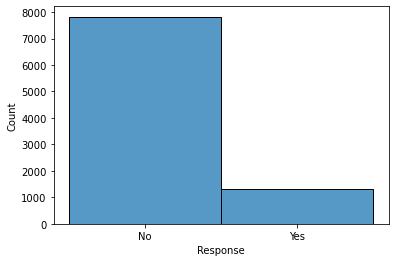



Response Rates: 


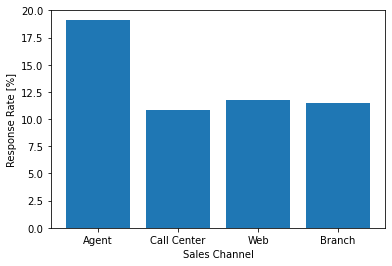

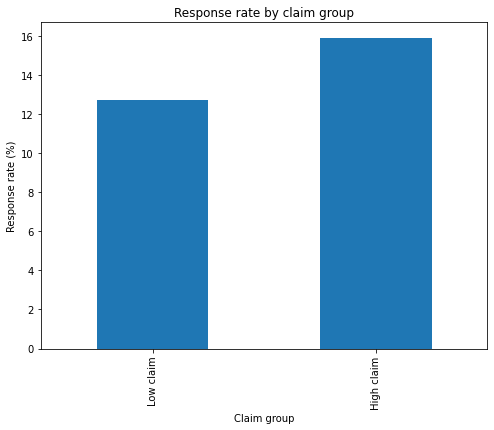

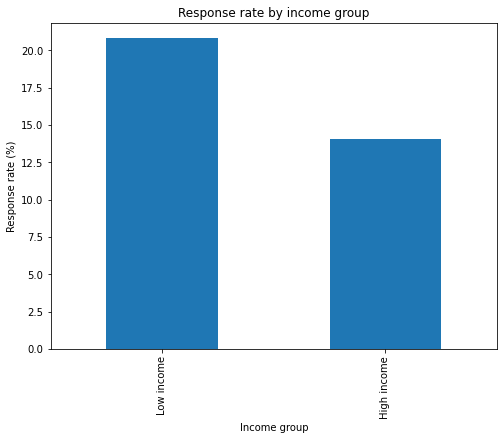


Numeric columns plots



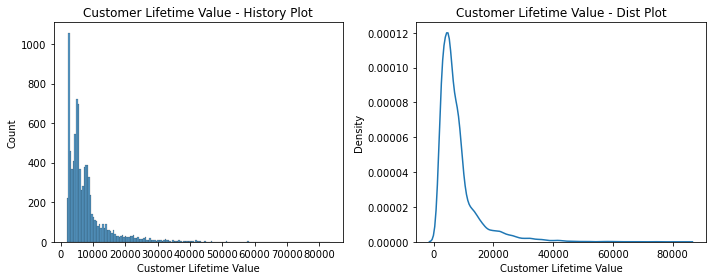

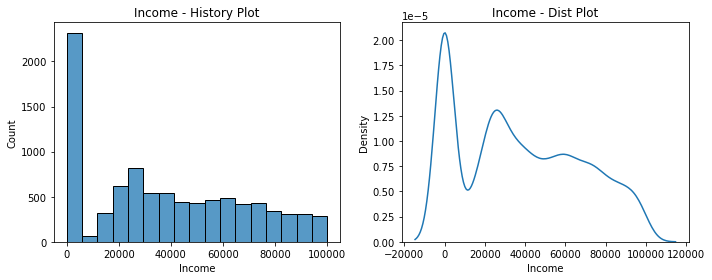

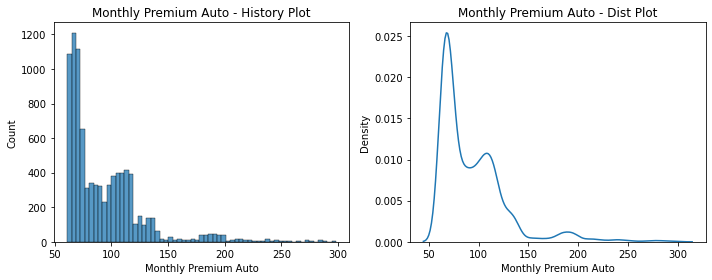

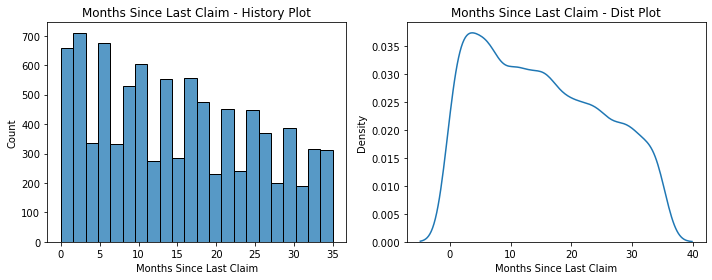

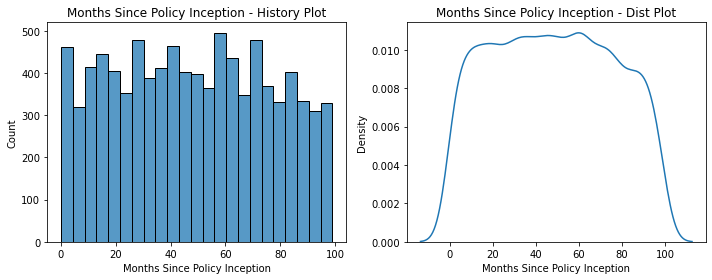

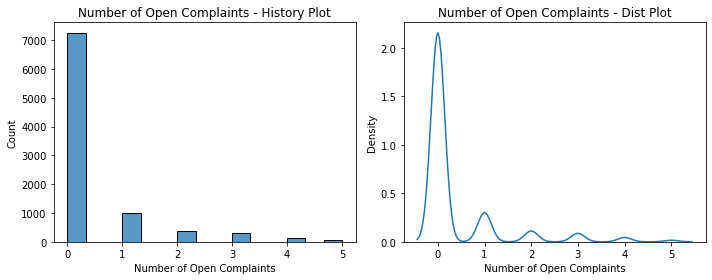

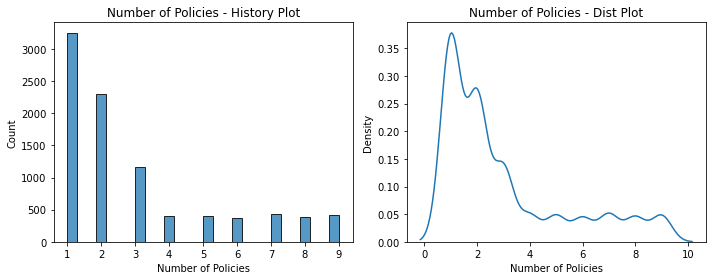

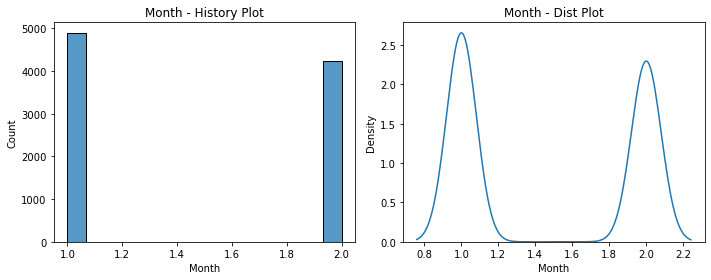


Correlation Heatmap



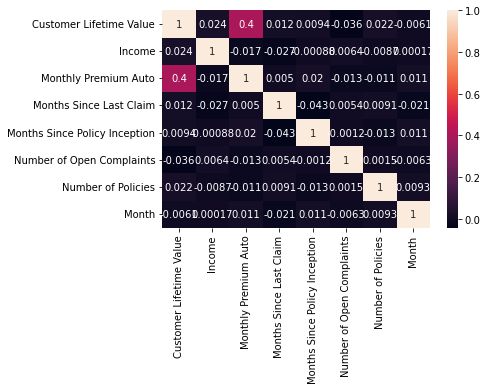

The following high-correlation columns were dropped:  ['Customer Lifetime Value', 'Monthly Premium Auto']

New numerical data: 


,Income,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Month
0,56274,32,5,0,1,2
1,0,13,42,0,8,1
2,48767,18,38,0,2,2
3,0,18,65,0,7,1
4,43836,12,44,0,1,2
...,...,...,...,...,...,...
9129,71941,18,89,0,2,2
9130,21604,14,28,0,1,2
9131,0,9,37,3,2,2
9132,21941,34,3,0,3,2




Normalizing with BoxCox


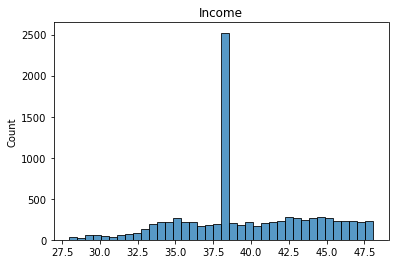

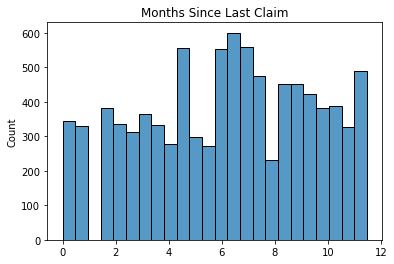

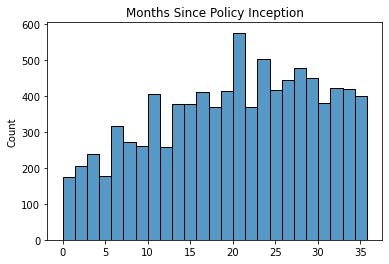

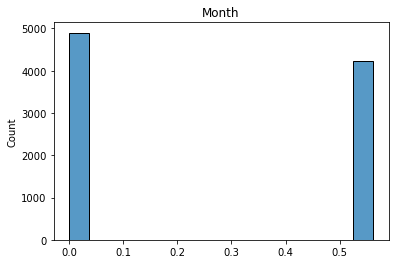

Applying One Hot


Final X data:


,Income,Months Since Last Claim,Months Since Policy Inception,Month,State_Arizona,State_California,State_Nevada,State_Oregon,State_Washington,Response_No,...,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small
0,42.114983,10.809132,3.017301,0.561741,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,38.346277,5.783269,18.770387,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,40.735368,7.311427,17.380225,0.561741,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,38.346277,7.311427,26.144855,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,39.734641,5.448624,19.451130,0.561741,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,44.579684,7.311427,33.067968,0.561741,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9130,33.627127,6.106927,13.703207,0.561741,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9131,38.346277,4.363742,17.026248,0.561741,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9132,33.751319,11.248499,1.667661,0.561741,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0




Train-test Split:


,y_test,predictions
0,396.105473,503.414323
1,413.492922,549.579462
2,333.696228,363.598890
3,558.099357,453.635948
4,806.400000,794.944561
...,...,...
2736,345.600000,370.968024
2737,494.400000,740.005802
2738,504.000000,578.779471
2739,662.715218,610.107731



R2 score:  0.7697635239434525
MSE:  20154.268854636473
RMSE:  141.96573126862862
MAE:  97.2949164767372




In [3]:
#test
custanalysis("files_for_lab\csv_files\marketing_customer_analysis.csv",0.3,0.3,90)

Data shape: (9134, 24)

Standardized data columns:  Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

Numerical Columns:  Index(['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies',
       'Total Claim Amount'],
      dtype='object')

Categorical Columns:  Index(['Customer', 'State', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marita

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Month
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,...,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,2
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,...,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,1
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,...,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,2
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,...,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,1
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,...,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2011-02-10,Employed,M,71941,...,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize,2
9130,PK87824,California,3096.511217,Yes,Extended,College,2011-02-12,Employed,F,21604,...,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize,2
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2011-02-06,Unemployed,M,0,...,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize,2
9132,UP19263,California,7524.442436,No,Extended,College,2011-02-03,Employed,M,21941,...,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large,2



Data description: 



,count,mean,std,min,25%,50%,75%,max
Customer Lifetime Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly Premium Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months Since Last Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months Since Policy Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number of Open Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number of Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total Claim Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678
Month,9134.0,1.463762,0.498712,1.000000,1.000000,1.000000,2.000000,2.000000




Count of Responses: 


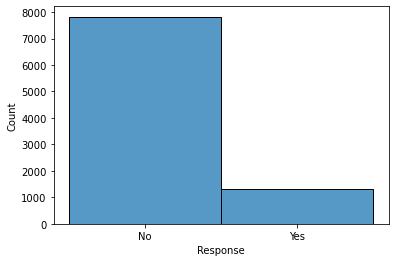



Response Rates: 


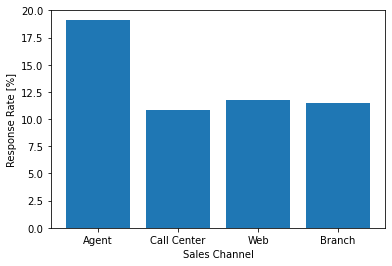

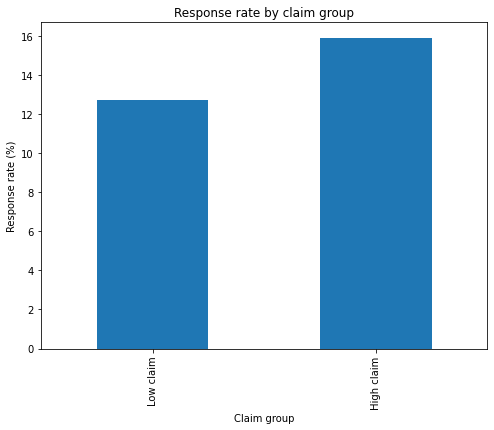

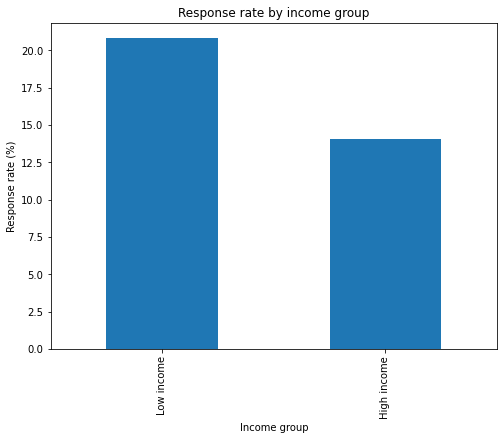


Numeric columns plots



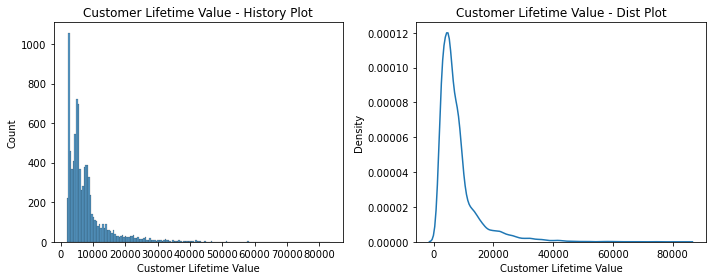

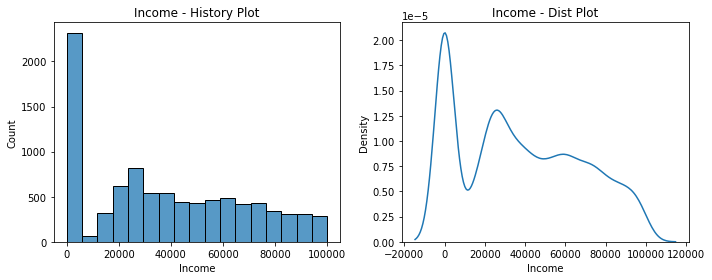

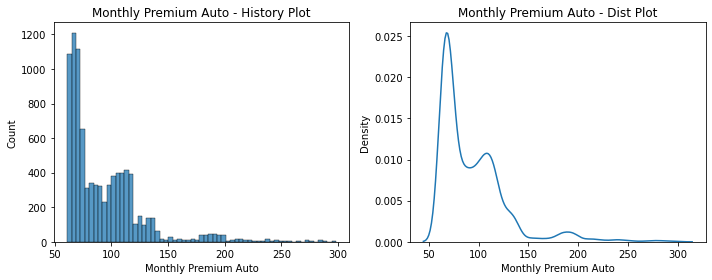

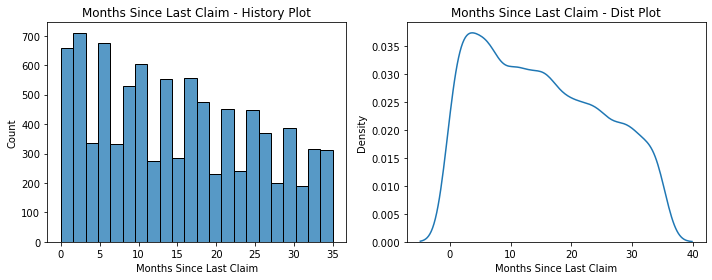

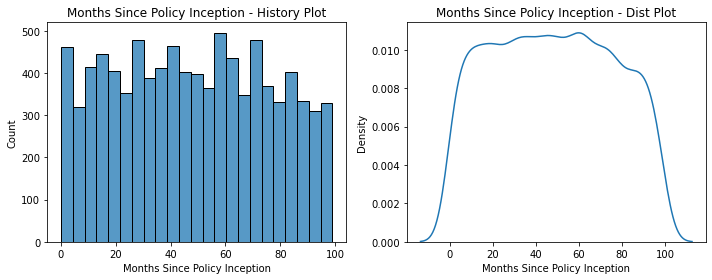

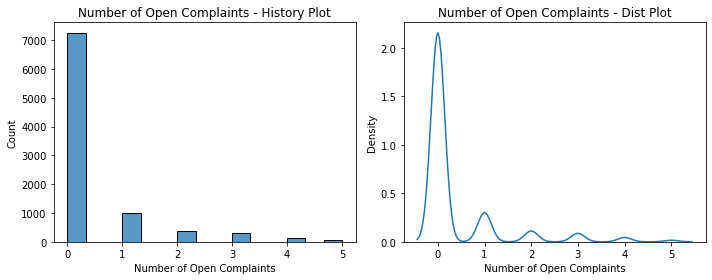

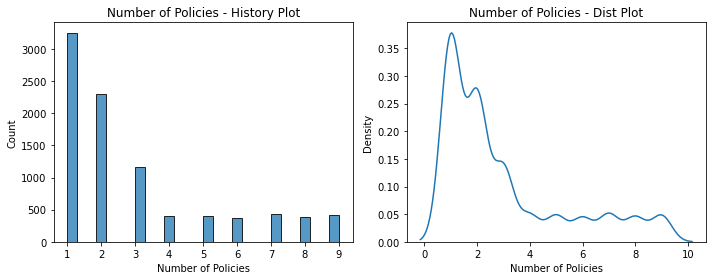

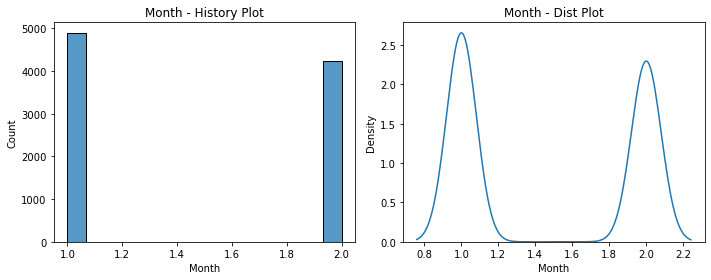


Correlation Heatmap



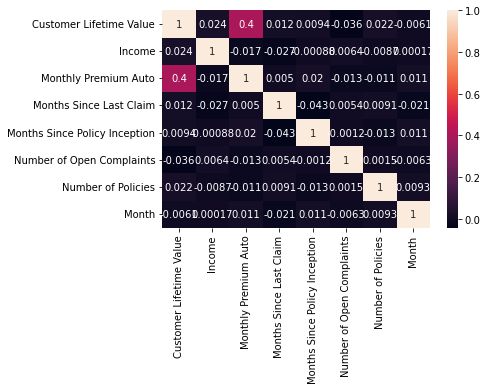

The following high-correlation columns were dropped:  ['Customer Lifetime Value', 'Monthly Premium Auto']

New numerical data: 


,Income,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Month
0,56274,32,5,0,1,2
1,0,13,42,0,8,1
2,48767,18,38,0,2,2
3,0,18,65,0,7,1
4,43836,12,44,0,1,2
...,...,...,...,...,...,...
9129,71941,18,89,0,2,2
9130,21604,14,28,0,1,2
9131,0,9,37,3,2,2
9132,21941,34,3,0,3,2




Normalizing with BoxCox


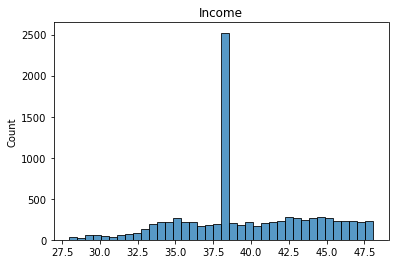

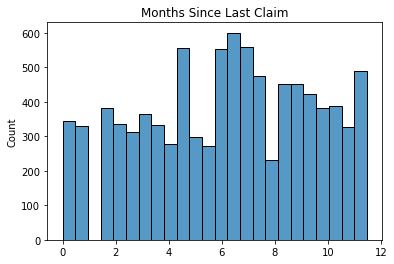

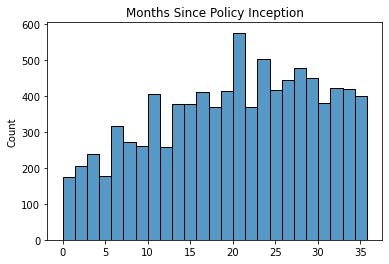

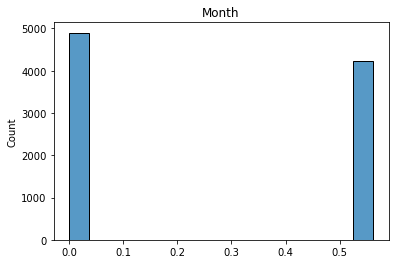

Applying One Hot


Final X data:


,Income,Months Since Last Claim,Months Since Policy Inception,Month,State_Arizona,State_California,State_Nevada,State_Oregon,State_Washington,Response_No,...,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small
0,42.114983,10.809132,3.017301,0.561741,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,38.346277,5.783269,18.770387,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,40.735368,7.311427,17.380225,0.561741,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,38.346277,7.311427,26.144855,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,39.734641,5.448624,19.451130,0.561741,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,44.579684,7.311427,33.067968,0.561741,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9130,33.627127,6.106927,13.703207,0.561741,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9131,38.346277,4.363742,17.026248,0.561741,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9132,33.751319,11.248499,1.667661,0.561741,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0




Train-test Split:


,y_test,predictions
0,396.105473,501.978140
1,413.492922,551.863854
2,333.696228,367.852256
3,558.099357,455.658615
4,806.400000,797.704871
...,...,...
3192,109.476994,119.059290
3193,657.600000,648.062047
3194,321.600000,383.834110
3195,679.392372,470.086159



R2 score:  0.7699240126438792
MSE:  19763.50366879743
RMSE:  140.58272891360954
MAE:  96.84925871895567




In [4]:
#test
custanalysis("files_for_lab\csv_files\marketing_customer_analysis.csv",0.3,0.35,90)